In [1]:
import pandas as pd
import os
from tqdm import tqdm
from utils import avg, evidence_to_mask, text_len_scatter

def to_data_df(df, data_dir):
    data_df = []
    columns = ['text', 'classification', 'rationale' ,'query']
    for i in tqdm(range(len(df))):
        df_row = df.loc[i]
        
        doc_id = df_row['annotation_id']
        query = df_row['query']
        evidence_list = df_row['evidences']
        if evidence_list:
            evidence_list = evidence_list[0]
        classification = df_row['classification']
        
        text = ''
        file = f'{data_dir}/docs/{doc_id}'
        if os.path.isfile(file):
            f = open(file, 'r', encoding="utf-8") 
            for line in f.readlines():
                text += line.rstrip() + ' '
        else:
            print("???")
            print(file)
            quit()
        
        tokens = text.split()
        rationale_mask = evidence_to_mask(tokens, evidence_list)
        
        # joining text and query with [SEP]
#         QA = f"{text}"
#         QA = f"{text}[SEP] {query}"
#         QA = f"{query} [SEP] {text}"
        
        QA = text
        rationale_mask = rationale_mask
    
        data_df.append([QA, classification, rationale_mask, query])
    data_df = pd.DataFrame(data_df, columns=columns)
#     return data_df
    
    data_df_shuffled=data_df.sample(frac=1).reset_index(drop=True)
    return data_df_shuffled

In [2]:
dataset = "movies"

In [3]:
data_dir = f'../data/{dataset}'
train = pd.read_json(f'{data_dir}/train.jsonl', lines=True)
test = pd.read_json(f'{data_dir}/test.jsonl', lines=True)
val = pd.read_json(f'{data_dir}/val.jsonl', lines=True)

In [4]:
train_data_df = to_data_df(train, data_dir)
# train_data_df.to_csv(f"{dataset}/train.csv",index_label="id")
test_data_df = to_data_df(test, data_dir)
# test_data_df.to_csv(f"{dataset}/test.csv",index_label="id")
val_data_df = to_data_df(val, data_dir)
# val_data_df.to_csv(f"{dataset}/val.csv",index_label="id")

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1625.49it/s]


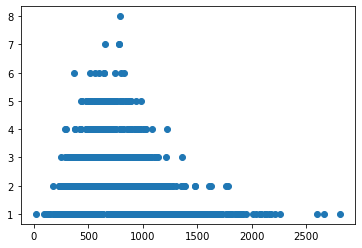

In [5]:
d = text_len_scatter(train_data_df,test_data_df,val_data_df)


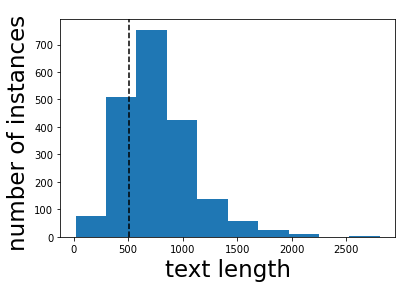

In [19]:
LABELSIZE = 23
all_texts = list(train_data_df['text']) + list(test_data_df['text']) + list(val_data_df['text'])
all_text_lens = [len(x.split()) for x in all_texts]
import matplotlib.pyplot as plt
plt.hist(all_text_lens)
plt.ylabel(ylabel="number of instances ", fontsize=LABELSIZE)
plt.xlabel(xlabel="text length", fontsize=LABELSIZE)
plt.axvline(x=512, linestyle="dashed", color="black")
plt.savefig("movies_distribution.png", bbox_inches = 'tight', dpi=300)
plt.show()

In [38]:
def generate_class_stats(train_df, test_df, val_df):
    text_lens_0 = []
    text_lens_1 = []
    rationale_lens_0 = []
    rationale_lens_1 = []
    rationale_percent_0 = []
    rationale_percent_1 = []
    class_distribution = [0,0]
    for df in [train_df, test_df, val_df]:
        for i in range(len(df)):
            df_row = df.loc[i]
            clas = df_row['classification']
            text = df_row['text']
            rationale = df_row['rationale']
            text_len = len(text.split())
            rationale_len = rationale.count(1)
            rationale_percent = rationale_len/text_len
            if clas == "NEG":
                text_lens_0.append(text_len)
                rationale_lens_0.append(rationale_len)
                rationale_percent_0.append(rationale_percent)
                class_distribution[0] += 1
            else:
                text_lens_1.append(text_len)
                rationale_lens_1.append(rationale_len)
                rationale_percent_1.append(rationale_percent)
                class_distribution[1] += 1
    return text_lens_0,text_lens_1,rationale_lens_0,rationale_lens_1,rationale_percent_0,rationale_percent_1,class_distribution

In [39]:
text_lens_0,text_lens_1,rationale_lens_0,rationale_lens_1,rationale_percent_0,rationale_percent_1,class_distribution = generate_class_stats(train_data_df,test_data_df,val_data_df)
text_lens_all = text_lens_0 + text_lens_1
rationale_lens_all = rationale_lens_0 + rationale_lens_1
rationale_percent_all = rationale_percent_0 + rationale_percent_1
class_distr = [class_distribution[0]/sum(class_distribution),class_distribution[1]/sum(class_distribution)]

In [40]:
for l in [rationale_lens_all,text_lens_all,rationale_percent_all,text_lens_0,text_lens_1,rationale_lens_0,rationale_lens_1,rationale_percent_0,rationale_percent_1]:
    print(avg(l))

30.925462731365684
774.2696348174087
0.04227329387265028
731.786
816.7957957957958
36.84
25.005005005005007
0.052422732743648545
0.03211369540318255


In [60]:
class_distr

[0.5002501250625313, 0.49974987493746875]